# Titanic Survival Prediction

## Introduction

The sinking of the Titanic is one of the most infamous wrecks in history. On April 15, 1912, during her maiden voyage, the RMS Titanic, widely considered “unsinkable”, sank after hitting an iceberg.

Unfortunately, there were not enough lifeboats for everyone on board, resulting in the deaths of 1,502 out of 2,224 passengers and crew. While there was an element of luck in survival, it appears that certain groups of people were more likely to survive than others.

Here, the challenge is to build a predictive model that can give a solution to the question, “What types of people were more likely to survive?”

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Getting data

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
test_data = pd.read_csv('test.csv')

### Exploratory Data Analysis

In [4]:
train_data.shape

(891, 12)

In [5]:
test_data.shape

(418, 11)

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Above we can see that 38% out of the training-set survived the Titanic. We can also see that the passenger ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values, like the ‘Age’ feature.

In [9]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From the above data we clearly see that there are null values in the Age, Cabin, Embarked columns. we have to fix it before using the data ahead because it will not give us best results.

#### Now we will look at detailed about which columns have missing data

In [10]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent_1 = train_data.isnull().sum()/train_data.isnull().count()*100
percent_2 = (round(percent_1,1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total','%'])
missing_data.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [11]:
train_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

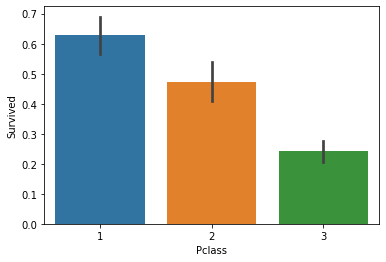

In [12]:
sns.barplot(x='Pclass', y='Survived', data=train_data)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1.

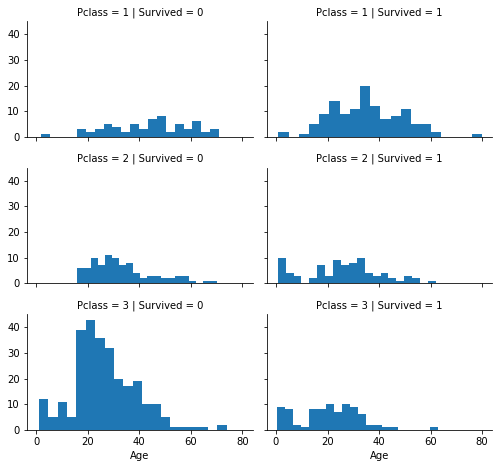

In [13]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)

The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

#### Now we will use SibSp and Parch which will shows the number of relatives

In [14]:
data = [train_data,test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset.Parch
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

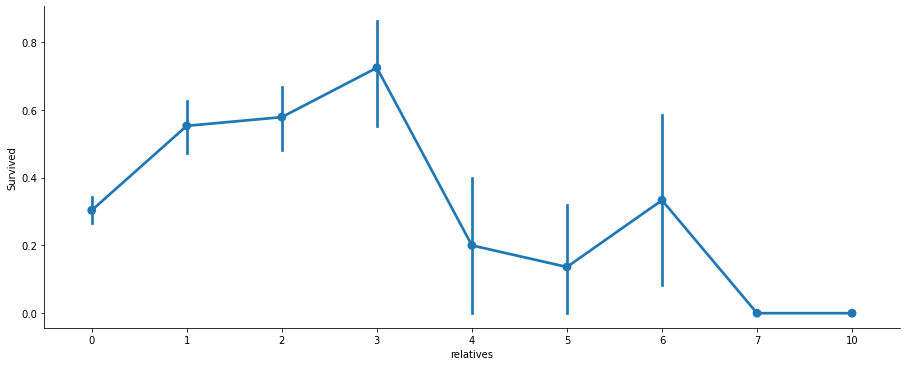

In [15]:
axes = sns.factorplot(data=train_data, x='relatives', y='Survived', aspect=2.5)

Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

## Data Preprocessing

First, I will drop PassengerId from the train set which is not contributing anything and it is already there in the test set which we can use for the submission.

In [16]:
train_data = train_data.drop(['PassengerId'], axis=1)

### Missing Data

In [17]:
train_data = train_data.drop(['Cabin'], axis=1)

In [18]:
test_data = test_data.drop(['Cabin'], axis=1)

#### Now we will deal with missing values in the Age column and will randomly assign numbers which are based on mean and standard deviation

In [19]:
data = [train_data, test_data]

for dataset in data:
    mean = train_data.Age.mean()
    std = train_data.Age.std()
    is_null = dataset.Age.isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    age_slice = dataset.Age.copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice
    dataset['Age'] = train_data.Age.astype(int)
    
train_data["Age"].isnull().sum()

0

In [20]:
train_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [21]:
common_value = 'S'
data = [train_data, test_data]

for dataset in data:
    dataset.Embarked = dataset.Embarked.fillna(common_value)

### Converting Features

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int32  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int32  
dtypes: float64(1), int32(2), int64(5), object(4)
memory usage: 76.7+ KB


#### Fare

In [23]:
# Converting "Fare" from float to int64 using astype() function of pandas library.

data = [train_data, test_data]
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Name

In [24]:
data = [train_data, test_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)

train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

#### Sex

In [25]:
# Converting Sex feature into numeric

genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Ticket

In [26]:
# Now we will drop ticket feature from both train and test set which has majority unique values.

train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

#### Embarked

In [27]:
# Converting Embarked feature into numeric.

ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

### Creating Categories

#### 1.  Age

In [28]:
data = [train_data, test_data]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed 
train_data['Age'].value_counts()

6    168
4    163
5    144
3    135
2    114
1     99
0     68
Name: Age, dtype: int64

#### 2. Fare

In [29]:
data = [train_data, test_data]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [30]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test = test_data.drop("PassengerId", axis=1).copy()

## Building Models

Now we will train several Machine Learning models and compare their results. Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other. Later on, we will use cross validation.

### Random Forest

In [33]:
rfmodel = RandomForestClassifier(n_estimators=100)
rfmodel.fit(X_train,Y_train)

y_pred = rfmodel.predict(X_test)
rfmodel.score(X_train,Y_train)
acc_rf = round(rfmodel.score(X_train,Y_train)*100, 2)

In [34]:
print(acc_rf)

91.47


### Decision Tree

In [35]:
dt = DecisionTreeClassifier()
dt.fit(X_train,Y_train)
dt_pred = dt.predict(X_test)
acc_dt = round(dt.score(X_train,Y_train)*100, 2)
acc_dt

91.47

### Logistic Regression

In [36]:
lr = LogisticRegression()
lr.fit(X_train,Y_train)
lr_pred = lr.predict(X_test)
acc_lr = round(lr.score(X_train,Y_train)*100, 2)
acc_lr

81.03

### K Nearest Neighbor

In [37]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
knn_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train,Y_train)*100, 2)
acc_knn

87.43

#### Which model is best?

In [38]:
results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Decision Tree'],
    'Score': [acc_knn, acc_lr, acc_rf, acc_dt]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head()

,Model
Score,
91.47,Random Forest
91.47,Decision Tree
87.43,KNN
81.03,Logistic Regression


not_alone and Parch are not playing significant role so i can drop it from the dataset.

In [39]:
train_data = train_data.drop(["not_alone", "Parch"], axis=1)
test_data = test_data.drop(["not_alone", "Parch"], axis=1)

### K-Fold Cross Validation

K-Fold Cross Validation randomly splits the training data into K subsets called folds. Let’s image we would split our data into 4 folds (K = 4). Our random forest model would be trained and evaluated 4 times, using a different fold for evaluation everytime, while it would be trained on the remaining 3 folds.

The result of our K-Fold Cross Validation example would be an array that contains 4 different scores. We then need to compute the mean and the standard deviation for these scores.

In [40]:
from sklearn.model_selection import cross_val_score
rf_model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf_model, X_train, Y_train, cv=10, scoring="accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.74444444 0.80898876 0.76404494 0.83146067 0.86516854 0.86516854
 0.83146067 0.80898876 0.84269663 0.83146067]
Mean: 0.8193882646691636
Standard Deviation: 0.0375072456259997


This looks much more realistic than before. Our model has a average accuracy of 82% with a standard deviation of 4 %. The standard deviation shows us, how precise the estimates are .

# Conclusion

As we have performed different models to get the best model which gives us the high score of the model for our titanic survival dataset. We have performed various thing like finding missing values, replacing missing values with the appropriate method, training the models, changing categorial column to numerical type.

We have used 4 models that are Random Forest, Logistic Regression, Decision Tree and K Nearest Neighbors from which we find that the Random Forest gives us the best result and we can say that with the use of random forest model we will get results much accurate for our titanic dataset.